In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from IPython import embed
from PIL import Image
from skimage import color

import matplotlib.pyplot as plt

import tensorflow as tf

## BaseColor

In [16]:
class BaseColor(nn.Module):
    def __init__(self):
        super(BaseColor, self).__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.

    def normalize_l(self, in_l):
        return (in_l-self.l_cent)/self.l_norm

    def unnormalize_l(self, in_l):
        return in_l*self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab/self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab*self.ab_norm

## Util

In [19]:
def load_img(img_path):
    out_np = np.asarray(Image.open(img_path))
    if(out_np.ndim==2):
        out_np = np.tile(out_np[:,:,None],3)
    return out_np

def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
    # return original size L and resized L as torch Tensors
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)

    img_lab_orig = color.rgb2lab(img_rgb_orig)
    img_lab_rs = color.rgb2lab(img_rgb_rs)

    img_l_orig = img_lab_orig[:,:,0]
    img_l_rs = img_lab_rs[:,:,0]

    tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
    tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

    return (tens_orig_l, tens_rs_l)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
    # tens_orig_l 1 x 1 x H_orig x W_orig
    # out_ab 1 x 2 x H x W

    HW_orig = tens_orig_l.shape[2:]
    HW = out_ab.shape[2:]

    # call resize function if needed
    if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
        out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
    else:
        out_ab_orig = out_ab

    out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
    return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

## ECCV16

In [20]:
class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

In [21]:
def eccv16(pretrained=True):
    model = ECCVGenerator()
    if(pretrained):
        import torch.utils.model_zoo as model_zoo
        model.load_state_dict(
            model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',
                               map_location='cpu',
                               check_hash=True)
        )
    return model

In [22]:
colorizer_eccv16 = eccv16(pretrained=True).eval()

## SIGGRAPH17

In [24]:
class SIGGRAPHGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d, classes=529):
        super(SIGGRAPHGenerator, self).__init__()

        # Conv1
        model1=[nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]
        # add a subsampling operation

        # Conv2
        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]
        # add a subsampling layer operation

        # Conv3
        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]
        # add a subsampling layer operation

        # Conv4
        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        # Conv5
        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        # Conv6
        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        # Conv7
        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        # Conv7
        model8up=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)]
        model3short8=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]

        model8=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[norm_layer(256),]

        # Conv9
        model9up=[nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True),]
        model2short9=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        # add the two feature maps above        

        model9=[nn.ReLU(True),]
        model9+=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model9+=[nn.ReLU(True),]
        model9+=[norm_layer(128),]

        # Conv10
        model10up=[nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True),]
        model1short10=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        # add the two feature maps above

        model10=[nn.ReLU(True),]
        model10+=[nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),]
        model10+=[nn.LeakyReLU(negative_slope=.2),]

        # classification output
        model_class=[nn.Conv2d(256, classes, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),]

        # regression output
        model_out=[nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),]
        model_out+=[nn.Tanh()]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8up = nn.Sequential(*model8up)
        self.model8 = nn.Sequential(*model8)
        self.model9up = nn.Sequential(*model9up)
        self.model9 = nn.Sequential(*model9)
        self.model10up = nn.Sequential(*model10up)
        self.model10 = nn.Sequential(*model10)
        self.model3short8 = nn.Sequential(*model3short8)
        self.model2short9 = nn.Sequential(*model2short9)
        self.model1short10 = nn.Sequential(*model1short10)

        self.model_class = nn.Sequential(*model_class)
        self.model_out = nn.Sequential(*model_out)

        self.upsample4 = nn.Sequential(*[nn.Upsample(scale_factor=4, mode='bilinear'),])
        self.softmax = nn.Sequential(*[nn.Softmax(dim=1),])

    def forward(self, input_A, input_B=None, mask_B=None):
        if(input_B is None):
            input_B = torch.cat((input_A*0, input_A*0), dim=1)
        if(mask_B is None):
            mask_B = input_A*0

        conv1_2 = self.model1(torch.cat((self.normalize_l(input_A),self.normalize_ab(input_B),mask_B),dim=1))
        conv2_2 = self.model2(conv1_2[:,:,::2,::2])
        conv3_3 = self.model3(conv2_2[:,:,::2,::2])
        conv4_3 = self.model4(conv3_3[:,:,::2,::2])
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)

        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3)
        conv8_3 = self.model8(conv8_up)
        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        return self.unnormalize_ab(out_reg)

In [25]:
def siggraph17(pretrained=True):
    model = SIGGRAPHGenerator()
    if(pretrained):
        import torch.utils.model_zoo as model_zoo
        model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth',map_location='cpu',check_hash=True))
    return model

In [26]:
colorizer_siggraph17 = siggraph17(pretrained=True).eval()

## Demo

In [48]:
# default size to process images is 256x256
# grab L channel in both original ("orig") and resized ("rs") resolutions
img_name = "ansel_adams3.jpg" 
img = load_img(img_name)
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

In [55]:
# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))

eccv16_colorized = colorizer_eccv16(tens_l_rs).cpu()
siggraph17_colorized = colorizer_siggraph17(tens_l_rs).cpu()

In [74]:
print(eccv16_colorized.detach().numpy().shape)
print(siggraph17_colorized.detach().numpy().shape)

accuracy = tf.keras.metrics.Accuracy()

y_true = siggraph17_colorized.detach().numpy()
y_pred = eccv16_colorized.detach().numpy()

accuracy.reset_state()
accuracy.update_state(y_true,y_pred)
accuracy.result().numpy()

(1, 2, 256, 256)
(1, 2, 256, 256)


0.0

In [57]:
out_img_eccv16 = postprocess_tens(tens_l_orig, eccv16_colorized)
out_img_siggraph17 = postprocess_tens(tens_l_orig, siggraph17_colorized)

In [58]:
print(out_img_eccv16.shape)
print(out_img_siggraph17.shape)

(675, 900, 3)
(675, 900, 3)


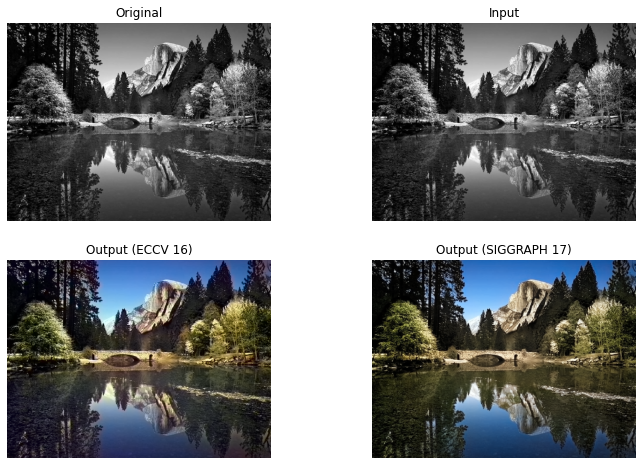

In [51]:
# plt.imsave(img_name+'_eccv16.png', out_img_eccv16)
# plt.imsave(img_name+'_siggraph17.png', out_img_siggraph17)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(out_img_siggraph17)
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()